63f78014766fd30436c18a79_Hyperspace - navbar logo.png

This notebook demonstrates the use of Hyperspace engine to create a movie recommendation system using Hybrid search, that combines classic search (keyword matching) with vector search. The notebook first demonstrates classic and vector search, followed by hybrid search, which combines classic and vector searches, by combining word embedding with metadata filtering.

Finally, we will use aggregations to analyze the gain insights on the returned documents.
The relevent score functions can be downloaded from the following links [score function 1](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/MovieRecommendation/movie_aggregation_function.py), [score function 2](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/MovieRecommendation/movies_score_function.py).


# Hyperspace Hybrid search
This notenook combines brute force KNN (accurate) with metadata filtering. In this scheme, Hyperspace uses the pre-filtering approach, by which the metadata is first filtered and the KNN is applied only on vectors that pass the initial filtering. For KNN, this approach optimizes the query latency, without reducing its recall.

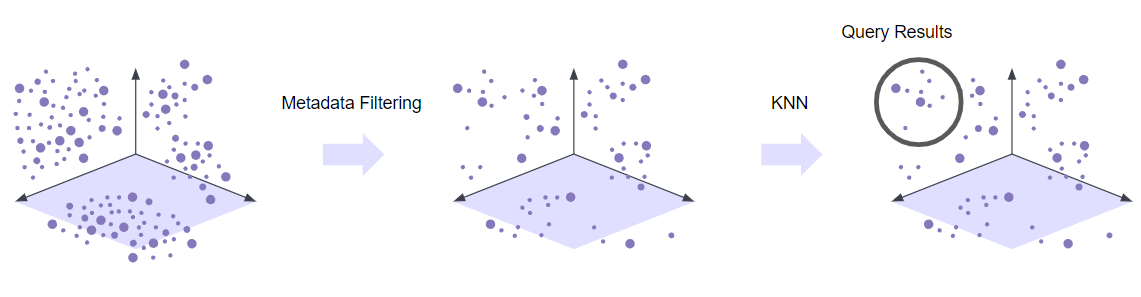


# The Dataset
The data is taken from [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/) and was downloaded from [Kaggle movie recommender system dataset ](https://www.kaggle.com/code/rounakbanik/movie-recommender-systems). The data includes 40951 valid movies. The data is in SQL format (table) and will be converted to NoSQL (documents) format. The data preprocessing is given in the notebook titles "MovieRecommendationDataPrep", available in this repository.

## The Dataset Fields
The processed [metadata](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/MovieRecommendation/Movie_Recommendation_Processed.csv) includes the following fields:

1.   **adult** [boolean] - states if the movie is rated 18+
2.   **belongs_to_collection** [Keyword] - name of the collection that includes the movie. If the movie is not a part of a collection, value will be "None"
3. **budget** [integer] - The budget of the movie in USD
4. **genres** [list[Keyword]] - list of movie genres (i.e drama)
5. **id** [integer]] - unique id per movie
6. **original_language** [Keyword] - the original language in which the movie was produced
7. **popularity** [float] - the popularity of the movie, formulated as an unbounded score
8. **production_companies** [list[Keyword]] - list of production companies involved in the movie
9. **production_countries** [list[Keyword]] - list of all countries in which the movie was filmed
10. **rating** [float] - the movie IMDB weighted average rating  score
11. **release_date_unix_time** [int] - the movie release date in unix time
12. **revenue** [float] - the movie rvenue in [USD]
13. **runtime_days** [int] - the number cinema run time days
14. **spoken_languages** [list[Keyword]] - list of all languages spoken in the movie
15. **title** [Keyword] - the movie title
16. **description embedding** [list[float]] - embedding of the movie tagline and description text


# Loading the Data
We first load the movie metadata in an SQL from from a csv file, using the pandas module. The data was previously processed in order to only include the relevant features. The data does not include vectors, and we will create them using simple TF-IDF embedding, in the next step.


In [ ]:
import pandas as pd
import warnings

data_path = "Movie_Recommendation_Processed.csv"

warnings.filterwarnings('ignore')
df = pd.read_csv(data_path)
df["runtime_days"] = df["runtime_days"].astype(int)
del(df["popularity"])

df.info()

Before start, let's examine some of the data columns

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

plt.subplot(1, 2, 1)
sns.histplot(data=df, x="budget", bins=20, color='blue', alpha=0.7)
plt.title("Budget Distribution")
plt.xlim(0.0, 1.25E8)
plt.xlabel("Budget")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="rating", bins=20, color='orange', alpha=0.7)
plt.title("Rating Distribution")
plt.xlabel("Rating")

plt.tight_layout()
plt.show()


It can be seen that the vast majority of movies have a budget lower than 20 million USD. The rating distribution is non-symmetric, with a maximum rating slightly above 5. We will incorporate these insights into the score function that we will soon build, providing positive and negative score boosts based on these statistics.

# Text Embedding
The next step is to embedd the text of movie overviews and the taglines. We use a simple TF-IDF based vectorization  (in contrast to a more sophisticated embedding using LLM such as BERT or GPT) using the SKLEARN TfidfVectorizer.
In this method, each vector element represnts a single word.
The first step will be to normalize the text and then replace rare words with base tense.

In [ ]:
#@title Normalize Text
import nltk
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint, pformat

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stopwords = list(stopwords.words('english'))
replacement_dict = {"Cheated":"Cheat","Photographs":"Photograph","Awfully":"Awful","Poisoner":"Poisoner","comix":"comics",
                    "embarrassingly":"embarrassing"}

def normalize_text(tagline):
    tagline = re.sub(r'\W', ' ', tagline)

    words = nltk.word_tokenize(tagline)
    normalized_words = [word for word in words if word.lower() not in ['be', 'is', 'are', 'am', 'was', 'were', 'been', 'being'] + stopwords]
    normalized_words = [lemmatizer.lemmatize(word, pos='v') for word in normalized_words if len(word) > 1 and not word.isdigit()]

    normalized_tagline = ' '.join(normalized_words)
    for key in replacement_dict:
      normalized_tagline = normalized_tagline.replace(key,replacement_dict[key])
    return normalized_tagline

df['belongs_to_collection'] = df['belongs_to_collection'].fillna(np.nan).replace([np.nan], [None])
df['tagline'] = df['tagline'].fillna("''")
df['tagline'] = df['tagline'].apply(normalize_text)
df['overview'] = df['overview'].apply(normalize_text)
replacement_dict = {"Cheated":"Cheat","Photographs":"Photograph","Awfully":"Awful","Poisoner":"Poisoner","comix":"comics",
                    "embarrassingly":"embarrassing"}


df["description text"] = df["overview"] + df["tagline"]
del(df["overview"])
del(df["tagline"])


# Filtering the TF-IDF vector
In order to maximize the relevance of the embedded vectors, we only keep meaningful words. That is, we remove extremley rare words (less than 10 appearences) and keep the rarest 2048 words of the remaining corpus. Note that Hyperspace can support vectors with dimension signficantly larger than 2048. The relevant words are stored under "top_terms".

Examples of the meaningful words are:
**'injure',
 'exhibit',
 'extend',
 'substance',
 'creator',
 'demented',
 'terminate',
 'absolute',
 'praise',
 'pant',
 'routine',
 'retaliate',
 'greatness',
 'insight',
 'resignation',
 'gradual',
 'carole',
 'khan',
 'commitment',
 'angel'**

In [ ]:
#@title TF-IDF Embedding

import math
embedding_vector_length = 2048

def normalize_euclidean_norm(input_list):
    if sum(input_list) < 0.0000000000000001:
      return input_list
    euclidean_norm = math.sqrt(sum(x ** 2 for x in input_list))
    normalized_list = [x / euclidean_norm for x in input_list]
    return normalized_list

def embedded_text(df_data, min_word_count):
  tfidf = TfidfVectorizer(token_pattern=r'\b\w+\b', stop_words="english", min_df=min_word_count)
  tfidf_matrix = tfidf.fit_transform(df_data)
  idf_values = tfidf.idf_
  top_terms_idx = idf_values.argsort()[::-1][:embedding_vector_length]
  top_terms = [list(tfidf.vocabulary_.keys())[i] for i in top_terms_idx]
  new_tfidf = TfidfVectorizer(vocabulary=top_terms)
  new_tfidf_matrix = new_tfidf.fit_transform(df_data)
  new_tfidf_matrix = round(100 * new_tfidf_matrix)/100
  tfidf_matrix = new_tfidf_matrix.toarray()
  new_col = df_data.copy()
  return list(tfidf_matrix), new_tfidf, top_terms

df["description embedding"], tfidf_model, top_terms = embedded_text(df["description text"], 10)
df["description embedding"] = df["description embedding"].map(lambda x: list(x))
df["description embedding"] = df["description embedding"].map(lambda x: normalize_euclidean_norm(x))
df.reset_index(inplace=True)


# Using the Hyperspace Engine
In the next step will Setting the environment requires the following steps


1. Install the client API
2. Connect to a server
3. Create data schema file
4. Create collection
5. Ingest data
6. Run query

## 1. Install the client API
Hyperspace API can be installed directly from git, using the following command:

In [ ]:
pip install git+https://github.com/hyper-space-io/hyperspace-py

## 2. Connect to a server

Once the Hyperspace API is installed, the database can be accessed by creating a local instance of the Hyperspace client. This step requires host address, username and password.

In [ ]:
import hyperspace
from getpass import getpass

hyperspace_client = hyperspace.HyperspaceClientApi(username=username, password=getpass("Password:"), host=host)


Before continuing, let us check that the cluster is live using the  "**collections_info()**" command

In [ ]:
status = hyperspace_client.collections_info()
display(status)

## 3.   Create a Data Schema File

Similarly to other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Here, we create a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" (inner product) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.

Here, we use standrad inner product (metric = IP) with exact KNN (index = brute_force).

In [ ]:
import json

config = {
  "configuration": {
    "adult": {
      "type": "boolean"
    },
    "belongs_to_collection": {
      "type": "keyword"
    },
    "budget": {
      "type": "integer"
    },
    "genres": {
      "struct_type": "list",
      "type": "keyword"
    },
    "id": {
      "type": "integer"
    },
    "original_language": {
      "type": "keyword"
    },
    "popularity": {
      "type": "float"
    },
    "production_companies": {
      "struct_type": "list",
      "type": "keyword"
    },
    "production_countries": {
      "struct_type": "list",
      "type": "keyword"
    },
    "rating": {
      "type": "float"
    },
    "release_date_unix_time": {
      "type": "date"
    },
    "revenue": {
      "type": "float"
    },
    "runtime_days": {
      "type": "integer"
    },
    "spoken_languages": {
      "struct_type": "list",
      "type": "keyword"
    },
    "title": {
      "type": "keyword"
    },
     "description embedding": {
            "type": "dense_vector",
            "dim": 2048,
            "index_type": "brute_force",
            "metric": "IP"
      }
  }
}

with open('MovieRecommendation_config.json', 'w') as f:
    f.write(json.dumps(config, indent=2))



## 4. Create Collection
The Hyerspace engine stroes data in Collections, where each collecction commonly hosts data of similar context, etc. Each search is then perfomed within a collection. We create a collection using the command "**create_collection**(schema_filename, collection_name)".

In [ ]:
collection_name = 'Movies'

try:
    hyperspace_client.delete_collection(collection_name)
except:
    pass
hyperspace_client.create_collection('MovieRecommendation_config.json', collection_name)
hyperspace_client.collections_info()

## 5. Ingest data

In the next step we ingest the dataset in batches of 500 documents to the Hyperspace database. This number can be controlled by user, and in particular, can be increased in order improve ingestion time. We add batches of data using the command **add_batch**(batch, collection_name).

In [ ]:
import time
BATCH_SIZE = 500

def chunker(df, size):
    return (df.iloc[pos:pos + size] for pos in range(0, len(df), size))

start = time.time()

i = 0

for chunk in chunker(df.iloc[i:], BATCH_SIZE):
    batch = [hyperspace.Document(str(i + j), row) for j, row in enumerate(chunk.to_dict('records'))]
    i += BATCH_SIZE

    if i % BATCH_SIZE == 0:
        response = hyperspace_client.add_batch(batch, collection_name)
        print(i, response)
        batch.clear()


hyperspace_client.commit('Movies')
time = (time.time() - start)
print(f"ingestion took: {time} sec")

## 6. Running The Query

### Creating The Query
Hyperspace queries are created in python format and saved as strings. Classic search requires a pre-created score function.

### Loading the score function
The score function encorporates logic based on movied budget and rating, and gives bonus to movies of similar production_companies. Only movies of the same genre are returned. We will use two score functions. The first is used only for matching similar movies, while the other will perform agrregrations on the returned data.

In [ ]:
sf_file = 'movies_score_function.py'
hyperspace_client.set_function(sf_file, collection_name=collection_name, function_name='popular_films_recommendation')

In [ ]:
sf_agg_file = 'movie_aggregation_function.py'
hyperspace_client.set_function(sf_agg_file, collection_name=collection_name, function_name='aggregation_films_recommendation')

The next step is use the query logic and apply the query. We will run a vector search, followed by a hybrid search which includes analytic logic - boost based on rating, genres, etc. Let's start with vector search.

### Vector Search
We start with a simple search function, based on matching of embedded vectors using inner product and accurate KNN

In [ ]:
input_vector = hyperspace_client.get_document(document_id='555', collection_name=collection_name)
pprint({x: input_vector[x] for x in input_vector if x!= "description embedding"})

As an input vector, we choose 'James and the Giant Peach', a children's movie by Disney pictures and Allied Filmmakers

In [ ]:
query_with_knn = {
    'params': input_vector,
    'knn': {
        'query': {'boost': 0},# boost = 0 -> no metadata filtering
        'description embedding': {'boost': 10}
    }

print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")
results = hyperspace_client.search(query,
                                        size=20,
                                        collection_name=collection_name)

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("-------------------------------------------------")


print("{:<5} {:<10} {:<40} {:<10}".format("Rank", "ID", "Title", "Score"))
print("="*65)

for i, result in enumerate(results['similarity']):
    api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    print("{:<5} {:<10} {:<40} {:<10}".format(i + 1, result['document_id'], api_response['title'][:40], round(result['score'], 2)))


### Classic Search
Let us use the score function, and run classic search (keyword matching). We require that the search will nor return the input movie in the score function.

In [ ]:
input_vector = hyperspace_client.get_document(document_id='555', collection_name=collection_name)

print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")

query = {
    'params': input_vector,
    "query": {"boost": 1}
    }

results = hyperspace_client.search(query,
                                        size=20,
                                        function_name='popular_films_recommendation',
                                        collection_name=collection_name)

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("------------------------------------------------------")


print("{:<5} {:<10} {:<40} {:<10}".format("Rank", "ID", "Title", "Score"))
print("="*65)

for i, result in enumerate(results['similarity']):
    api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    print("{:<5} {:<10} {:<40} {:<10}".format(i + 1, result['document_id'], api_response['title'][:40], round(result['score'], 2)))



### Hybrid Search
In the next step we apply Hybrid search, which combines classic and vector search.

In [ ]:
input_vector = hyperspace_client.get_document(document_id='555', collection_name=collection_name)

print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")

query_with_knn = {
    'params': input_vector,
    'knn': {
        'query': {'boost': 0.1},# boost = 0 -> no metadata filtering
        'description embedding': {'boost': 10}
    }

results = hyperspace_client.search(query,
                                        size=20,
                                        function_name='aggregation_films_recommendation',
                                        collection_name=collection_name)

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("------------------------------------------------------")


print("{:<5} {:<10} {:<40} {:<10}".format("Rank", "ID", "Title", "Score"))
print("="*65)

for i, result in enumerate(results['similarity']):
    api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    print("{:<5} {:<10} {:<40} {:<10}".format(i + 1, result['document_id'], api_response['title'][:40], round(result['score'], 2)))

It can be seen that for vector search, the recommended movies are not necessarily relevant - while the original movie was a children's movie, the returned movies are not always under this category. By contrast, all the returned movies in the classic search appear suitable. The results of the classic and Hybrid search are similar, likley due to the limited embedding method we used that has little contirbution.

# Hybrid Search and Agggregations
In the final part, we will use a different score function to aggregatre various fields of the data. The aggregation is perfomed in the score function, where each aggregation is perfomed over all candidates that passed the filtering up to the step that hosts it.

In [ ]:
input_vector = hyperspace_client.get_document(document_id='555', collection_name=collection_name)

print("searching for matches for '",input_vector["title"],"'")
print("-------------------------------------------------")

query = {
    'params': input_vector,
    "knn": {
        "query": {"boost": 1},
        "description embedding": {
            "boost": 200,
        }
    }
}

results = hyperspace_client.search(query,
                                        size=10,
                                        function_name='aggregation_films_recommendation',
                                        collection_name=collection_name)

candidates = results['candidates']

print(f"Query run time = {results['took_ms']}ms")
print("------------------------------------------------------")


print("{:<5} {:<10} {:<40} {:<10}".format("Rank", "ID", "Title", "Score"))
print("="*65)

for i, result in enumerate(results['similarity']):
    api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
    print("{:<5} {:<10} {:<40} {:<10}".format(i + 1, result['document_id'], api_response['title'][:40], round(result['score'], 2)))


print("\n----------------- Aggregations --------------------")
print("{:<50} {:<15}".format("Aggregation", "Value"))
print("="*55)

for i, agg in enumerate(results['aggregations']):
    if results['aggregations'][agg]['agg_type'] == "count":
        print("{:<50} {:<15}".format(agg, results['aggregations'][agg]["count"]))
    else:
        print("{:<50} {:<15}".format(agg, round(results['aggregations'][agg]["value"],2)))

This notebook gave a simple example of the use of the Hyperspace engine for hybrid search. Hyperspace can support signficantly more complicated use cases with large databases, in extremley low latency.
For more information, visit us at [Hyperspace](https://www.hyper-space.io/)